# Training the Titanic model

The ML model we will use here is XGBoost Classifier.

## Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import utils as ut
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [2]:
raw_df = ut.load_data()
df = ut.preprocess_data(raw_df)
# print(df.drop('Survived', axis=1).head())
# df['Survived']

In [3]:
raw_df = ut.load_data()
df = ut.preprocess_data(raw_df)
dmatrix = xgb.DMatrix(data=df.drop('Survived', axis=1), label=df['Survived'])
X_train, y_train, X_val, y_val, X_test, y_test = ut.split_data(df)
# print type of each column in X_train
print(X_train.dtypes)

Age           float64
SibSp           int64
Parch           int64
Ticket        float64
Fare          float64
Room          float64
Pclass_1        uint8
Pclass_2        uint8
Pclass_3        uint8
Sex_female      uint8
Sex_male        uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
Deck_A          uint8
Deck_B          uint8
Deck_C          uint8
Deck_D          uint8
Deck_E          uint8
Deck_F          uint8
Deck_G          uint8
Deck_T          uint8
dtype: object


### Data preview

In [4]:
print('Data shapes:\n')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val:   ', X_val.shape)
print('y_val:   ', y_val.shape)
print('X_test:  ', X_test.shape)
print('y_test:  ', y_test.shape)

df.head()

Data shapes:

X_train:  (712, 22)
y_train:  (712,)
X_val:    (89, 22)
y_val:    (89,)
X_test:   (90, 22)
y_test:   (90,)


,Survived,Age,SibSp,Parch,Ticket,Fare,Room,Pclass_1,Pclass_2,Pclass_3,...,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,22.0,1,0,21171.0,7.2500,NaN,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,1,38.0,1,0,17599.0,71.2833,85.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,26.0,0,0,3101282.0,7.9250,NaN,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,35.0,1,0,113803.0,53.1000,123.0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,35.0,0,0,373450.0,8.0500,NaN,0,0,1,...,0,1,0,0,0,0,0,0,0,0


## Pretuned model

In [5]:
default_params = {
    'random_state': 0,
    'missing': np.nan,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_estimators': 1000,
    # 'early_stopping_rounds': 10,
    # 'learning_rate': 0.1,
    # 'max_depth': 3,
    # 'subsample': 0.8,
    # 'colsample_bytree': 1,
    # 'alpha': 0.3,
    # 'lambda': 1,
    # 'gamma': 1,

    # 'tree_method': 'gpu_hist'
}

xgb_model = xgb.XGBClassifier()


In [6]:
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:

result = xgb_model.evals_result()
print()

In [8]:
pretune_train_accuracy, pretune_validation_accuracy = ut.eval_xgb_model(xgb_model, X_train, y_train, X_val, y_val, verbose=True)

Train accuracy:      99.72%
Validation accuracy: 82.02%


Out pretuned model has a high train accuracy of 99.58%, while the validation accuracy is at 76.40%, indicating that the model is overfitting the training data. 

## Fine tuning

To address the issue of overfitting and hopefully getting a better validation accuracy, we will fine tune our model by trying different values for the hyperparameters and finding the values that give the best score

### Choosing the right evaluation metric

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        46
           1       0.89      0.72      0.79        43

    accuracy                           0.82        89
   macro avg       0.83      0.82      0.82        89
weighted avg       0.83      0.82      0.82        89



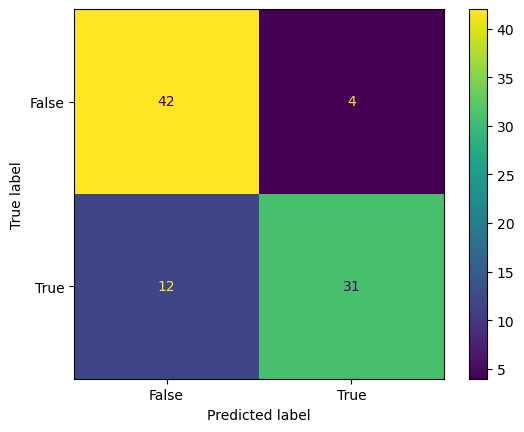

In [9]:
# printing the classification report
actual = y_val
predicted = xgb_model.predict(X_val)
print(metrics.classification_report(actual, predicted))
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Since positive and negative classes are quite balanced, and false positives are as important as false negatives we can use accuracy as the evaluation metric.

### Searching for the best parameters

To find the best parameters for our model we will iterate over many possible values of a parameter while leaving the other parameters constant until we find the best value, then we will move to the next parameter

In [10]:
num_values = 10

paramsTuningValues = {
    'learning_rate': np.linspace(0.01, 0.3, num_values),
    'early_stopping_rounds': np.linspace(0, 100, num_values, dtype=int),
    'max_depth': np.linspace(1, 10, num_values, dtype=int),
    'subsample': np.linspace(0, 1, num_values),
    'colsample_bytree': np.linspace(0, 1, num_values),
    'colsample_bylevel': np.linspace(0, 1, num_values),
    'colsample_bynode': np.linspace(0, 1, num_values),
    'min_child_weight': np.linspace(0, 100, num_values),
    'max_delta_step': np.linspace(0, 100, num_values),
    'alpha': np.linspace(0, 100, num_values),
    'lambda': np.linspace(0, 100, num_values),
    'gamma': np.linspace(0, 100, num_values),
    'scale_pos_weight': np.linspace(0, 1, num_values),
}

iterations = 0

for _ in range(iterations):
    for param in paramsTuningValues:
      best_score, best_value, scores = ut.tune_xgb_model(
          xgb_model, X_train, y_train, X_val, y_val, default_params, param, paramsTuningValues[param], 'logloss', plot=False,  overwriteParams=True)
      print(f'Best {param}: {best_value}')


In [11]:
params_tuning_ranges = {
    'learning_rate': [0.01, 0.3],
}


def xgb_autotuner(xgb_model, X_train, y_train, X_val, y_val, default_params, tuning_ranges,
                  iterations=5, num_values=10, eval_metric='logloss', plot=False, overwrite_params=False):

  ranges = tuning_ranges.copy()
  tuned_params = default_params.copy()
  for _ in range(iterations):
    # shrink the tuning ranges
    # for param in params:
    #   step = (ranges[param][1] - ranges[param][0])/num_values
    #   ranges[param][0] = params[param] - step
    #   ranges[param][1] = params[param] + step
    #   if (ranges[param][0] < params_tuning_ranges[0]):
    #     ranges[param][0] = params_tuning_ranges[0]
    #   if (ranges[param][1] > params_tuning_ranges[1]):
    #     ranges[param][1] = params_tuning_ranges[1]

    for param in ranges:
      values = np.linspace(ranges[param][0], ranges[param][1], num_values,
                           dtype=type(ranges[param][0]))
      ut.tune_xgb_model(xgb_model, X_train, y_train, X_val, y_val,
                        tuned_params, param, values, eval_metric,
                        plot, overwrite_params=True)
  return tuned_params


In [17]:
tuning_ranges = {
    # 'learning_rate': [0.01, 0.3],
    # 'early_stopping_rounds': [0, 100],
    # 'max_depth': [1, 10],
    # 'subsample': [0., 1.],
    # 'colsample_bytree': [0., 1.],
    # 'colsample_bylevel': [0., 1.],
    # 'colsample_bynode': [0., 1.],
    'min_child_weight': [0, 100],
    'max_delta_step': [0, 100],
    'alpha': [0, 100],
    'lambda': [0, 100],
    'gamma': [0, 100],
    'scale_pos_weight': [0, 1],
}

xgb_autotuner(xgb_model, X_train, y_train, X_val, y_val, default_params, tuning_ranges,
              iterations=1, num_values=10, eval_metric='logloss')


{'random_state': 0,
 'missing': nan,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'n_estimators': 1000,
 'min_child_weight': 0,
 'max_delta_step': 0,
 'alpha': 0,
 'lambda': 88,
 'gamma': 0,
 'scale_pos_weight': 1}

In [ ]:
num_values = 10
default_range = [0, 1]
_range = default_range.copy()
x = 0.04

step = (_range[1] - _range[0])/num_values
_range[0] = x - step
_range[1] = x + step
if (_range[0] < default_range[0]):
    _range[0] = default_range[0]
if (_range[1] > default_range[1]):
    _range[1] = default_range[1]
  
print(_range)


In [ ]:
print('Final params')
default_params

In [ ]:
xgb_model = xgb.XGBClassifier(**default_params)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)


### Evaluating the tuned model

In [ ]:
tuned_train_accuracy, tuned_validation_accuracy = ut.eval_xgb_model(xgb_model, X_train, y_train, X_val, y_val, verbose=True)

train_accuracy_gain = tuned_train_accuracy - pretune_train_accuracy
validation_accuracy_gain = tuned_validation_accuracy - pretune_validation_accuracy

print(f'Train accuracy gain:      {train_accuracy_gain:.2%}')
print(f'Validation accuracy gain: {validation_accuracy_gain:.2%}')

test_accuracy, _ = ut.eval_xgb_model(xgb_model, X_test, y_test, X_test, y_test, verbose=False)
print(f'Test accuracy: {test_accuracy:.2%}')

In [ ]:
# xgb.plot_importance(xgb_model)